ARから作ったデータで、ニューラルを線形にする

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0_2" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein

In [2]:
phi_a = [1.0, -0.5, 0.7, -0.4]
phi_b = [0]
p = len(phi_a)
q = len(phi_b)
dataSeed=0
N = 1000
data = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal')
inno = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal', return_innovation=True)

### 非線形ARで同じARMAモデル時系列を推定してちゃんとmseが下がるかどうか
を確認する

まずは、AR(p)を仮定したモデリングを行う。つまり、中間層は一次元。最初はAIC最小と言われた$\hat p=4$でやる

In [3]:
# ARモデルにおけるの次数をaicで推定
from statsmodels.tsa.ar_model import ar_select_order
mod = ar_select_order(data, maxlag=13)
mod.ar_lags

array([1, 2, 3, 4])

In [4]:
hat_p = 4
hat_q = 0

In [5]:
# 学習する推定モデルの形状や学習方法なんかを決定します
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
parser.add_argument("--training_seed", type=int, default=0, help="訓練データを学習させる順番を決めるシード")
parser.add_argument("--n_epochs", type=int, default=2000, help="学習させる回数")

opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用

opt.batch_size=128

In [6]:
os.makedirs("output-images/p{0}".format(hat_p), exist_ok=True)
os.makedirs("parameters/p{0}".format(hat_p), exist_ok=True)

In [7]:
import checkGPU
cuda, device = checkGPU.checkGPU()

GPUは使えません。


In [8]:
import models
torch.manual_seed(opt.generator_seed)
generator = models.Generator(p = p, q=q)

In [9]:
a= torch.rand([opt.batch_size,1,p+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = generator(a)
print("output size:",b.shape)

input size   : torch.Size([128, 1, 5])
output size: torch.Size([128, 2])


In [10]:
class predictNet(nn.Module):
    def __init__(self, p=7, n_unit1=16, n_unit2=16):
        super(predictNet, self).__init__()
        
        self.fc1 = nn.Linear(p+1,1, bias=False)

        
    def forward(self,x):
        x = self.fc1(x)
        return x

In [11]:
torch.manual_seed(opt.predictor_seed)
predictor = predictNet(p=hat_p)

In [12]:
a= torch.rand([opt.batch_size, hat_p+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = predictor(a)
print("output size:",b.shape)

input size   : torch.Size([128, 5])
output size: torch.Size([128, 1])


In [13]:
optimizer_G = torch.optim.Adam(params=generator.parameters() )
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.0001 )
# optimizer_F = torch.optim.RMSprop(params=predictor.parameters())

In [14]:
mseLoss = nn.MSELoss()

In [15]:
# パラメータと学習データをGPUに乗っける
generator.to(device)
predictor.to(device)
mseLoss = mseLoss.to(device)

In [16]:
# 学習方法の決定？

In [17]:
def make_XY(x:np.ndarray, p:int):
    x = torch.tensor(x, dtype=torch.float)
    X = [x[i:i+p] for i in range(len(x)-p)]
    Y = [x[i+p] for i in range(len(x)-p)]
    return X, Y

In [18]:
class DataSet:
    def __init__(self, tsData, hat_p):
        """
        tsData：時系列データ（今回は一次元の時系列を想定）
        hat_p　：想定する次数
        initで入力データと出力データを作成する。
        """
        self.tsData =  torch.tensor(tsData, dtype=torch.float) # torch.tensorに変換
        self.hat_p = hat_p
        self.X, self.Y = make_XY(self.tsData, self.hat_p)
    
    def  __len__(self):
        return len(self.X) # データ数を返す
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [19]:
dataset = DataSet(data, hat_p=hat_p)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)# dataloaderをiterで回すと、毎回入力と出力のペアがlistでくる

In [20]:
# class withoutDiscriminator:
#     """
#     提案手法
#     """
#     def __init__(self, tsData, hat_p):
#         self.X = 
#         pass
    
#     def fit(self):
#         pass
    
#     def predict(self, x):
#         pass

epoch：1/1000   loss_F： 4.5499   経過時間： 0.0秒
epoch：2/1000   loss_F： 4.5679   経過時間： 0.0秒
epoch：3/1000   loss_F： 4.6217   経過時間： 0.0秒
epoch：4/1000   loss_F： 4.5478   経過時間： 0.0秒
epoch：5/1000   loss_F： 4.4995   経過時間： 0.1秒
epoch：6/1000   loss_F： 4.4410   経過時間： 0.1秒
epoch：7/1000   loss_F： 4.5252   経過時間： 0.1秒
epoch：8/1000   loss_F： 4.6060   経過時間： 0.1秒
epoch：9/1000   loss_F： 4.5470   経過時間： 0.1秒
epoch：10/1000   loss_F： 4.4655   経過時間： 0.1秒
epoch：11/1000   loss_F： 4.4476   経過時間： 0.1秒
epoch：12/1000   loss_F： 4.4843   経過時間： 0.1秒
epoch：13/1000   loss_F： 4.3385   経過時間： 0.1秒
epoch：14/1000   loss_F： 4.4646   経過時間： 0.1秒
epoch：15/1000   loss_F： 4.3954   経過時間： 0.1秒
epoch：16/1000   loss_F： 4.2507   経過時間： 0.2秒
epoch：17/1000   loss_F： 4.4927   経過時間： 0.2秒
epoch：18/1000   loss_F： 4.4838   経過時間： 0.2秒
epoch：19/1000   loss_F： 4.3830   経過時間： 0.2秒
epoch：20/1000   loss_F： 4.4233   経過時間： 0.2秒
epoch：21/1000   loss_F： 4.4699   経過時間： 0.2秒
epoch：22/1000   loss_F： 4.4050   経過時間： 0.2秒
epoch：23/1000   loss_F： 4.3854   経過時間： 0.

epoch：188/1000   loss_F： 3.6069   経過時間： 2.0秒
epoch：189/1000   loss_F： 3.5803   経過時間： 2.0秒
epoch：190/1000   loss_F： 3.6606   経過時間： 2.0秒
epoch：191/1000   loss_F： 3.6214   経過時間： 2.0秒
epoch：192/1000   loss_F： 3.6188   経過時間： 2.0秒
epoch：193/1000   loss_F： 3.6126   経過時間： 2.0秒
epoch：194/1000   loss_F： 3.6146   経過時間： 2.0秒
epoch：195/1000   loss_F： 3.6925   経過時間： 2.0秒
epoch：196/1000   loss_F： 3.5013   経過時間： 2.0秒
epoch：197/1000   loss_F： 3.5622   経過時間： 2.1秒
epoch：198/1000   loss_F： 3.6123   経過時間： 2.1秒
epoch：199/1000   loss_F： 3.6251   経過時間： 2.1秒
epoch：200/1000   loss_F： 3.5704   経過時間： 2.1秒
epoch：201/1000   loss_F： 3.6666   経過時間： 2.1秒
epoch：202/1000   loss_F： 3.6241   経過時間： 2.1秒
epoch：203/1000   loss_F： 3.5620   経過時間： 2.1秒
epoch：204/1000   loss_F： 3.6112   経過時間： 2.1秒
epoch：205/1000   loss_F： 3.6023   経過時間： 2.1秒
epoch：206/1000   loss_F： 3.5885   経過時間： 2.2秒
epoch：207/1000   loss_F： 3.6544   経過時間： 2.2秒
epoch：208/1000   loss_F： 3.6129   経過時間： 2.2秒
epoch：209/1000   loss_F： 3.6398   経過時間： 2.2秒
epoch：210/

epoch：380/1000   loss_F： 3.4403   経過時間： 3.9秒
epoch：381/1000   loss_F： 3.5287   経過時間： 3.9秒
epoch：382/1000   loss_F： 3.3761   経過時間： 4.0秒
epoch：383/1000   loss_F： 3.4015   経過時間： 4.0秒
epoch：384/1000   loss_F： 3.3635   経過時間： 4.0秒
epoch：385/1000   loss_F： 3.4167   経過時間： 4.0秒
epoch：386/1000   loss_F： 3.3729   経過時間： 4.0秒
epoch：387/1000   loss_F： 3.3868   経過時間： 4.0秒
epoch：388/1000   loss_F： 3.3810   経過時間： 4.0秒
epoch：389/1000   loss_F： 3.3946   経過時間： 4.0秒
epoch：390/1000   loss_F： 3.3794   経過時間： 4.0秒
epoch：391/1000   loss_F： 3.3908   経過時間： 4.1秒
epoch：392/1000   loss_F： 3.4033   経過時間： 4.1秒
epoch：393/1000   loss_F： 3.4339   経過時間： 4.1秒
epoch：394/1000   loss_F： 3.3764   経過時間： 4.1秒
epoch：395/1000   loss_F： 3.4257   経過時間： 4.1秒
epoch：396/1000   loss_F： 3.3713   経過時間： 4.1秒
epoch：397/1000   loss_F： 3.4197   経過時間： 4.1秒
epoch：398/1000   loss_F： 3.4084   経過時間： 4.1秒
epoch：399/1000   loss_F： 3.4455   経過時間： 4.1秒
epoch：400/1000   loss_F： 3.3990   経過時間： 4.1秒
epoch：401/1000   loss_F： 3.4465   経過時間： 4.2秒
epoch：402/

epoch：563/1000   loss_F： 3.3452   経過時間： 5.9秒
epoch：564/1000   loss_F： 3.2578   経過時間： 5.9秒
epoch：565/1000   loss_F： 3.2847   経過時間： 5.9秒
epoch：566/1000   loss_F： 3.2828   経過時間： 5.9秒
epoch：567/1000   loss_F： 3.2871   経過時間： 5.9秒
epoch：568/1000   loss_F： 3.3955   経過時間： 5.9秒
epoch：569/1000   loss_F： 3.3997   経過時間： 5.9秒
epoch：570/1000   loss_F： 3.3495   経過時間： 5.9秒
epoch：571/1000   loss_F： 3.3222   経過時間： 5.9秒
epoch：572/1000   loss_F： 3.3920   経過時間： 5.9秒
epoch：573/1000   loss_F： 3.3320   経過時間： 6.0秒
epoch：574/1000   loss_F： 3.3180   経過時間： 6.0秒
epoch：575/1000   loss_F： 3.2503   経過時間： 6.0秒
epoch：576/1000   loss_F： 3.2545   経過時間： 6.0秒
epoch：577/1000   loss_F： 3.2947   経過時間： 6.0秒
epoch：578/1000   loss_F： 3.3033   経過時間： 6.0秒
epoch：579/1000   loss_F： 3.2588   経過時間： 6.0秒
epoch：580/1000   loss_F： 3.2761   経過時間： 6.0秒
epoch：581/1000   loss_F： 3.2648   経過時間： 6.0秒
epoch：582/1000   loss_F： 3.2710   経過時間： 6.0秒
epoch：583/1000   loss_F： 3.3367   経過時間： 6.1秒
epoch：584/1000   loss_F： 3.3140   経過時間： 6.1秒
epoch：585/

epoch：754/1000   loss_F： 3.1802   経過時間： 7.9秒
epoch：755/1000   loss_F： 3.2434   経過時間： 7.9秒
epoch：756/1000   loss_F： 3.2783   経過時間： 7.9秒
epoch：757/1000   loss_F： 3.2533   経過時間： 7.9秒
epoch：758/1000   loss_F： 3.2314   経過時間： 7.9秒
epoch：759/1000   loss_F： 3.3149   経過時間： 7.9秒
epoch：760/1000   loss_F： 3.2521   経過時間： 7.9秒
epoch：761/1000   loss_F： 3.2321   経過時間： 7.9秒
epoch：762/1000   loss_F： 3.1734   経過時間： 8.0秒
epoch：763/1000   loss_F： 3.2385   経過時間： 8.0秒
epoch：764/1000   loss_F： 3.2440   経過時間： 8.0秒
epoch：765/1000   loss_F： 3.3132   経過時間： 8.0秒
epoch：766/1000   loss_F： 3.3162   経過時間： 8.0秒
epoch：767/1000   loss_F： 3.2141   経過時間： 8.0秒
epoch：768/1000   loss_F： 3.2403   経過時間： 8.0秒
epoch：769/1000   loss_F： 3.2354   経過時間： 8.0秒
epoch：770/1000   loss_F： 3.1262   経過時間： 8.0秒
epoch：771/1000   loss_F： 3.2698   経過時間： 8.0秒
epoch：772/1000   loss_F： 3.2774   経過時間： 8.1秒
epoch：773/1000   loss_F： 3.2706   経過時間： 8.1秒
epoch：774/1000   loss_F： 3.2248   経過時間： 8.1秒
epoch：775/1000   loss_F： 3.2580   経過時間： 8.1秒
epoch：776/

epoch：939/1000   loss_F： 3.2921   経過時間： 9.8秒
epoch：940/1000   loss_F： 3.2452   経過時間： 9.8秒
epoch：941/1000   loss_F： 3.2184   経過時間： 9.8秒
epoch：942/1000   loss_F： 3.0883   経過時間： 9.9秒
epoch：943/1000   loss_F： 3.1998   経過時間： 9.9秒
epoch：944/1000   loss_F： 3.2590   経過時間： 9.9秒
epoch：945/1000   loss_F： 3.1842   経過時間： 9.9秒
epoch：946/1000   loss_F： 3.2630   経過時間： 9.9秒
epoch：947/1000   loss_F： 3.2667   経過時間： 9.9秒
epoch：948/1000   loss_F： 3.3040   経過時間： 9.9秒
epoch：949/1000   loss_F： 3.2925   経過時間： 9.9秒
epoch：950/1000   loss_F： 3.2657   経過時間： 9.9秒
epoch：951/1000   loss_F： 3.1801   経過時間： 10.0秒
epoch：952/1000   loss_F： 3.2424   経過時間： 10.0秒
epoch：953/1000   loss_F： 3.2580   経過時間： 10.0秒
epoch：954/1000   loss_F： 3.2877   経過時間： 10.0秒
epoch：955/1000   loss_F： 3.2199   経過時間： 10.0秒
epoch：956/1000   loss_F： 3.2236   経過時間： 10.0秒
epoch：957/1000   loss_F： 3.2421   経過時間： 10.0秒
epoch：958/1000   loss_F： 3.3389   経過時間： 10.0秒
epoch：959/1000   loss_F： 3.2324   経過時間： 10.0秒
epoch：960/1000   loss_F： 3.2674   経過時間： 10.0秒


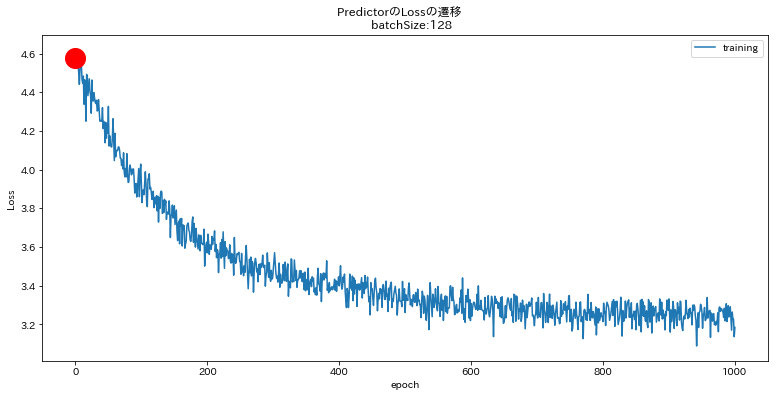

In [21]:
# 学習データの使い方のシードを決定
random.seed(a=opt.training_seed)

# ---------
# Fのpretrain
# ---------
n_epoch_pre = 1000
loss_F_pre = []
# Lossの遷移の履歴に学習前の状態のLossを加える
a=0
for X, Y in dataloader:
    input_tensor = torch.cat([torch.zeros([opt.batch_size,1]).to(device), Variable(X).to(device)], axis=1)
    a+=(mseLoss(predictor(input_tensor), Y.to(device))).item()
loss_F_pre.append(a/len(dataloader))

pretrain_param = 'parameters/p{0}/No{1}_predictor_epoch{2}_batchSize{3}_DataSeed{4}.pth'.format(hat_p, No, 0, opt.batch_size, dataSeed )

start=time.time()

for epoch in range(n_epoch_pre):
    epoch_loss = 0
    for X, Y in dataloader:
        input_tensor = torch.cat([torch.randn([opt.batch_size,1]).to(device), X.to(device)], axis=1)# ランダムな次元を追加
        optimizer_F.zero_grad()
        loss_F = mseLoss(predictor(input_tensor), Y.to(device))
        loss_F.backward()
        optimizer_F.step()
        epoch_loss += loss_F.item()
    loss_F_pre.append(epoch_loss/len(dataloader))
    print("epoch：{0}/{1}   loss_F：{2: .4f}   経過時間：{3: .1f}秒".format(epoch+1, n_epoch_pre, round(loss_F_pre[-1], 4), time.time()-start))

torch.save(predictor.state_dict(), pretrain_param)

plt.figure(figsize=(13,6))
plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_F_pre, label="training")
plt.plot(0,loss_F_pre[0], marker='o', markersize=20, color="red")
plt.legend()
plt.savefig("output-images/p{0}/No{1}_preloss_batchSize{3}_DataSeed{4}.png".format(hat_p, No, epoch, opt.batch_size, dataSeed ))
# plt.close()

In [22]:
predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0008,  0.0304, -0.0328,  0.0056,  0.0048]]))])

### 学習できてるのか確かめる

#### 学習前のpredictorと学習後のpredictorのtestLossを比較する

In [23]:
# testData = tsModel.ARIMA(a=phi_a, b=phi_b, N=1000, random_seed=2**32-1, randomness='normal')
testData = data
testdataset = DataSet(testData, hat_p=hat_p)
testdataloader = torch.utils.data.DataLoader(testdataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)

OrderedDict([('fc1.weight', tensor([[-0.3914,  0.2776, -0.1179, -0.2072, -0.1294]]))])


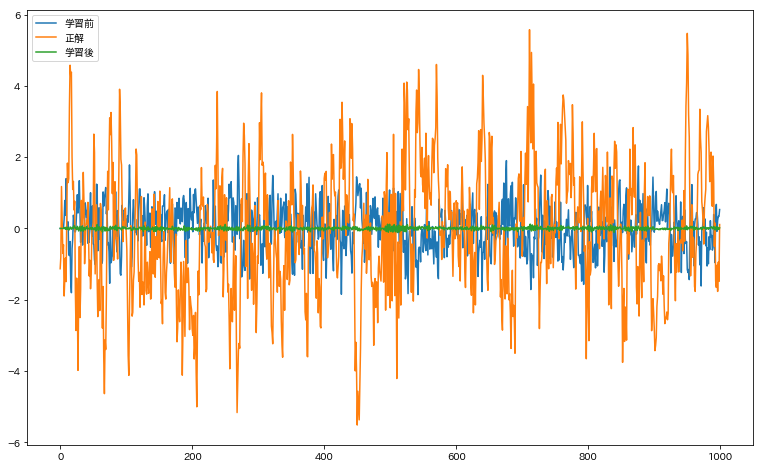

In [25]:
torch.manual_seed(203)
predictor = predictNet(p=hat_p)
print(predictor.state_dict())
pred = []
for i in range(1000):
    if i < 6:
        pred.append(0)
    else:
        ret = torch.cat([torch.randn(1,1), torch.tensor(testData[i-hat_p:i], dtype=torch.float).view(1,-1)], axis = 1)
        ret = predictor(ret)
        pred.append(ret.item())
    
plt.figure(figsize=(13,8))
plt.plot(pred, label="学習前")
plt.plot(testData, label = "正解")

predictor.load_state_dict(torch.load(pretrain_param)) 
pred = []
for i in range(1000):
    if i < 6:
        pred.append(0)
    else:
        ret = torch.cat([torch.randn(1,1), torch.tensor(testData[i-hat_p:i], dtype=torch.float).view(1,-1)], axis = 1)
        ret = predictor(ret)
        pred.append(ret.item())
plt.plot(pred, label="学習後")
plt.legend()

In [ ]:
data.mean()
data.std()

学習してない

In [ ]:
predictor.state_dict()